<h1><center>Part 2: Sentiment Analysis </center></h1>

In part 2, we use the result found in part 1 to analyze the sentiment of the selected product. To do so, We use two metrics : 
1. Customer Satisfaction Score (CSAT).
2. The Net Promoter Score (NPS).

In the end of this part, We compare the result of two methods BERT and GPT.

## 1. Data import

#### Import of different libraries that will be used in this part of the project.

In [2]:
import pandas as pd
import re
import math
from collections import Counter
import matplotlib.pyplot as plt
import pygal
from IPython.display import SVG, display
import numpy as np


In [3]:
# Read the already saved file from part 1
dat = pd.read_csv('asin_sample_GPT_Rev.csv')

In [4]:
# drop non necessary data
data = dat.drop(['Unnamed: 0','reviewerID','asin','summary','unixReviewTime','reviewText_deep_clean'], axis=1)

In [5]:
# check the data
data

,overall,vote,verified,reviewText,reviewText_clean,year,month,Sentiment_Score,Sentiment_GPT_Score,Reviewer_Type
0,5,2,No,Im not buying the GE one again. This one works...,im not buying the ge one again. this one works...,2014,7,5,0,-1
1,5,2,Yes,Removed the GE MWF Smartwater filter inserted ...,removed the ge mwf smartwater filter inserted ...,2014,7,5,1,0
2,4,2,Yes,This a good filter and fits our needs quite we...,this a good filter and fits our needs quite we...,2014,6,5,1,1
3,3,5,No,Update: Within hours of my posting this review...,update: within hours of my posting this review...,2014,6,3,0,0
4,5,30,Yes,I have a GE two door refrigerator and use to b...,i have a ge two door refrigerator and use to b...,2014,6,5,1,1
...,...,...,...,...,...,...,...,...,...,...
3194,5,0,Yes,"Snapped in no problem, filters ok, lasted abou...","snapped in no problem, filters ok, lasted abou...",2018,7,4,0,0
3195,5,0,Yes,I have ordered this filter from this seller mu...,i have ordered this filter from this seller mu...,2018,7,5,1,1
3196,5,0,Yes,Why spend $400 more a year for some name brand...,why spend $400 more a year for some name brand...,2018,7,1,-1,-1
3197,5,0,Yes,Filter works great so much so I just reordered...,filter works great so much so i just reordered...,2018,7,5,1,1


## 2. Sentiment analysis

In this section, we analyze the evolution of the sentiment over the years by ploting the total number of positive, negative and neutral reviews for each year. This will allow to see if the satisfaction of the costumers is acceptable or not and if there are any drops. 

In [6]:
# Count % of Positive, Negative and Neutral
counts_sent = Counter(data['Sentiment_GPT_Score'])
Positive = counts_sent[1]
Negative = counts_sent[-1]
Neutral = counts_sent[0]
counts_sent['Positive'] = counts_sent.pop(1)
counts_sent['Negative'] = counts_sent.pop(-1)
counts_sent['Neutral'] = counts_sent.pop(0)

<BarContainer object of 3 artists>

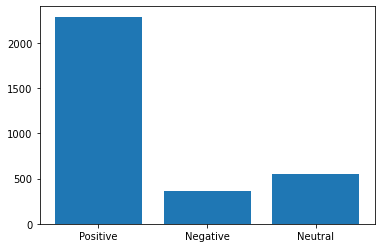

In [7]:
plt.bar(counts_sent.keys(), counts_sent.values())

In [13]:
counts_sent

Counter({'Positive': 2288, 'Negative': 360, 'Neutral': 551})

**Comment** : From this plot, we can see that the majority (2288) of the customers have a positive sentiment about their exeprience. However, there is a 911 customers with either neutral or negative experience. 

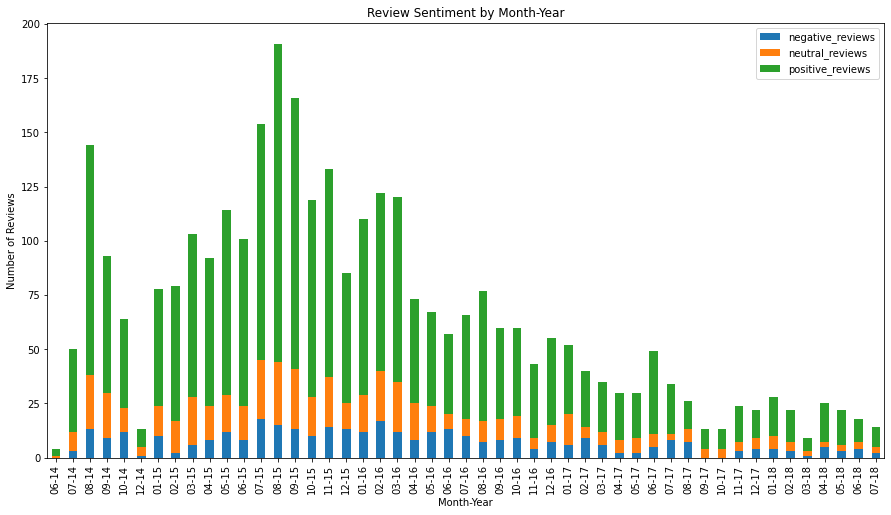

In [14]:
# Plot the sentiment over the years 

data_Sent = data[['year','month','Sentiment_GPT_Score']]
# rearrange the data_Sent dataframe
grouped_reviews = data_Sent.groupby(['year', 'month', 'Sentiment_GPT_Score'])['Sentiment_GPT_Score'].count().unstack(fill_value=0)
grouped_reviews = grouped_reviews.reset_index()

# rename the columns
grouped_reviews.columns = ['year', 'month', 'negative_reviews', 'neutral_reviews', 'positive_reviews']

# assuming the grouped_reviews dataframe
grouped_reviews['month-year'] = pd.to_datetime(grouped_reviews['year'].astype(str) + '-' + grouped_reviews['month'].astype(str))
stacked_reviews = grouped_reviews.drop(columns=['year', 'month'])

# format the month-year column
stacked_reviews['month-year'] = stacked_reviews['month-year'].dt.strftime('%m-%y')

# create the stacked bar chart
fig, ax = plt.subplots(figsize=(15,8))
stacked_reviews.plot(kind='bar', stacked=True, x='month-year', ax=ax)

ax.set_xlabel('Month-Year')
ax.set_ylabel('Number of Reviews')
ax.set_title('Review Sentiment by Month-Year')

plt.show()


**Comment** : From this stack box plot, we can see that the positive reviews are consistent over the years. We can tell that it looks like the customers are satisfied in the majority of time and the product kept the same quality.

## 3. Customer Satisfaction Score (CSAT)

<h4><center>CSAT%= (#) of Positive Responses / (#) total responses X100</center></h4>


**CSAT, or customer satisfaction score, is a commonly used metric that indicates how satisfied customers are with a company’s products or services. It’s measured through customer feedback and expressed as a percentage (100% would be fantastic – 0% would be terrible).**

**CSAT is calculated at predetermined periods, such as just after a purchase, during onboarding, during a customer support interaction, and so on. In our case the customers, provide usualy their reviews after purchase or during customer support, which is good fit**


In [229]:
# CSAT calculation
denominator_CSAT = stacked_reviews['positive_reviews'] + stacked_reviews['negative_reviews'] + stacked_reviews['neutral_reviews']
numerator_CSAT = stacked_reviews['positive_reviews'] 
stacked_reviews['CSAT'] = round((numerator_CSAT / denominator_CSAT) * 100,2)
CSAT_Global = round((numerator_CSAT.sum() / denominator_CSAT.sum()) * 100,2)

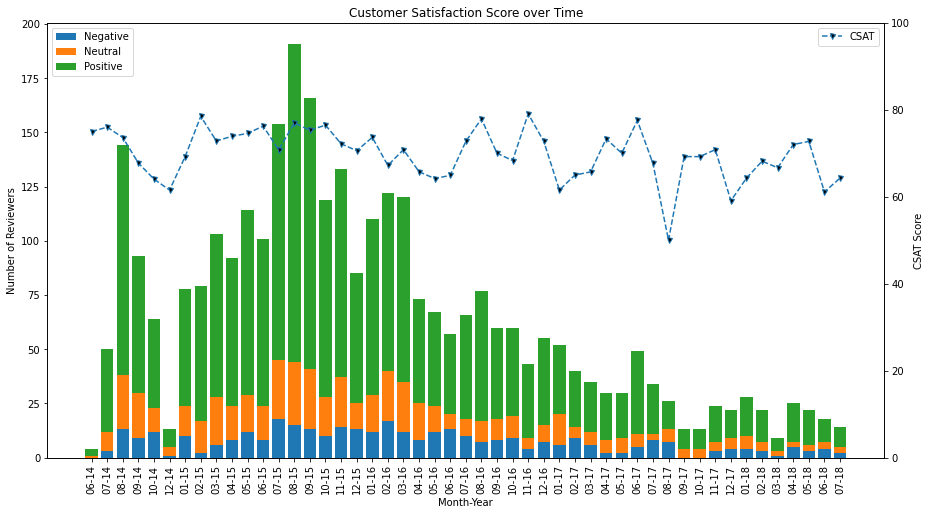

In [245]:
# CSAT ovre year
df_csat = stacked_reviews

# set figure size
fig, ax1 = plt.subplots(figsize=(15,8))

# plot stacked bar for detractors, passives, and promoters
plt.bar(df_csat['month-year'], df_csat['negative_reviews'], label='Negative')
plt.bar(df_csat['month-year'], df_csat['neutral_reviews'], bottom=df_csat['negative_reviews'], label='Neutral')
plt.bar(df_csat['month-year'], df_csat['positive_reviews'], bottom=df_csat['negative_reviews']+df_csat['neutral_reviews'], label='Positive')

# set labels and legend for primary y-axis
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Number of Reviewers')
ax1.set_title('Customer Satisfaction Score over Time')
ax1.legend(loc='upper left')

# create secondary y-axis for NPS score
ax2 = ax1.twinx()

# plot continuous line for NPS score
ax2.plot(df_csat['month-year'], df_csat['CSAT'], label='CSAT', linestyle='dashed', marker='v', markerfacecolor='black', markersize=5)

# set labels and legend for secondary y-axis
ax2.set_ylim(-0, 100)
ax2.set_ylabel('CSAT Score')
ax2.legend()

# rotate x-axis labels to be vertical
ax1.tick_params(axis='x', rotation=90)

# display plot
plt.show()


**Comment** : From the above chart, we can see that the CSAT score is fluctuating around 70% for all years. This is a very good sign regarding the satisfaction of the customers about this product. It shows that even when the volume is high (between 2015 and 2016) the satisfaction score kept the same performance. We can notice some drops (in August 2017) but it was related avery low volume, 20 reviews, this shouldn' affect the overall performance of the CSAT score.

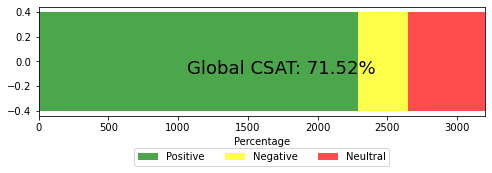

In [241]:
# Calculation of the overall CSAT
# Define the data for the plot
positive_reviews = stacked_reviews['positive_reviews'].sum()
negative_reviews = stacked_reviews['negative_reviews'].sum()
neutral_reviews = stacked_reviews['neutral_reviews'].sum()
csat_score = CSAT_Global
total = denominator_CSAT.sum()

# Create the plot
fig, ax = plt.subplots(figsize=(8, 2))

# Plot the promoters
ax.barh(y=0, width=positive_reviews, color='green', alpha=0.7, label='Positive')

# Plot the passives on top of the promoters
ax.barh(y=0, width=negative_reviews, color='yellow', alpha=0.7, label='Negative', left=positive_reviews)

# Plot the detractors on top of the passives and promoters
ax.barh(y=0, width=neutral_reviews, color='red', alpha=0.7, label='Neultral', left=positive_reviews+negative_reviews)

# Set the x-axis limit and label
ax.set_xlim([0, total])
ax.set_xlabel('Percentage')

# Add the NPS score text to the plot
ax.text(total/3, -0.1, f'Global CSAT: {csat_score}%', fontsize=18)

# Add a legend to the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)

# Show the plot
plt.show()

**Comment** : The overall CSAT score is 71.53% which is a great one. It tells that 71.52% of all the costumers that provided a review are satisfied with their choice. More this score is high more is good to the business.

## 4. The Net Promoter Score (NPS)

 <h4><center>NPS= % of Promoters – % of Detractors</center></h4>


**The Net Promoter Score (NPS) is a metric for determining customer loyalty and, as a result, the likelihood of future purchases and referrals. A Net Promoter Score determines whether or not a customer is likely to suggest the product. 
Any positive NPS rating means that the product owner has more advocates (promoters) willing to recommend their product than critics (detractors). A score of -100 means that every one of the customers is a detractor. On the other end of the spectrum, +100 means that everybody is a promoter. Good NPS score ranges depend on a few factors.**

**A low score can disclose evident faults with the customer service personnel, such as a delay in responding to support tickets or extended hold periods on the phone.**



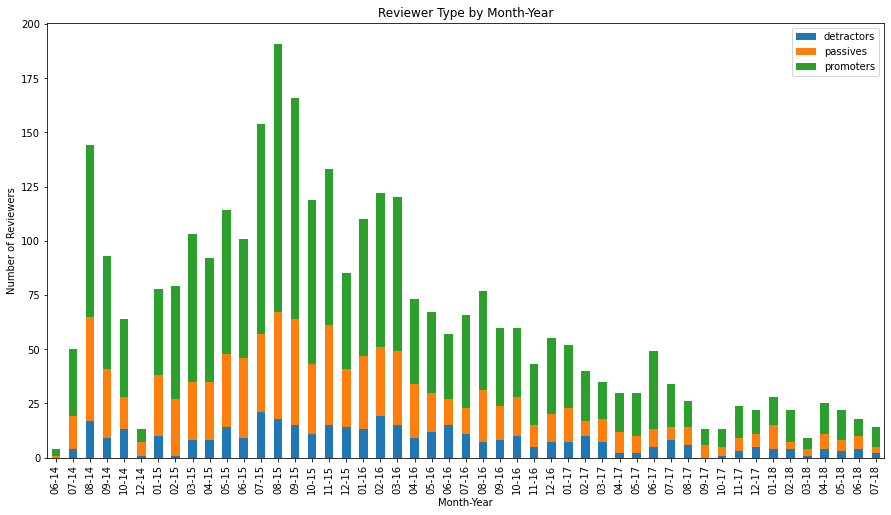

In [17]:
# using data from part 1. let's plot the number of type of customer per years.
data_NPS = data[['year','month','Reviewer_Type']]
# rearrange the data_NPS dataframe
grouped_NPS = data_NPS.groupby(['year', 'month', 'Reviewer_Type'])['Reviewer_Type'].count().unstack(fill_value=0)
grouped_NPS = grouped_NPS.reset_index()

# rename the columns 
grouped_NPS.columns = ['year', 'month', 'detractors', 'passives', 'promoters']

# assuming the grouped_reviews dataframe
grouped_NPS['month-year'] = pd.to_datetime(grouped_NPS['year'].astype(str) + '-' + grouped_NPS['month'].astype(str))
stacked_NPS = grouped_NPS.drop(columns=['year', 'month'])

# format the month-year column
stacked_NPS['month-year'] = stacked_NPS['month-year'].dt.strftime('%m-%y')

# create the stacked bar chart
fig, ax = plt.subplots(figsize=(15,8))
stacked_NPS.plot(kind='bar', stacked=True, x='month-year', ax=ax)

ax.set_xlabel('Month-Year')
ax.set_ylabel('Number of Reviewers')
ax.set_title('Reviewer Type by Month-Year')

plt.show()


**Comment:** We can see from the above chart that the number of  promters is significantly higher than the detractors. This observation look stable over the years. The passives also are significant, this is mainly due to the model estimation.

In [18]:
# Calculation of the NPS over years.
denominator = stacked_NPS['promoters'] + stacked_NPS['detractors'] + stacked_NPS['passives']
numerator = stacked_NPS['promoters'] - stacked_NPS['detractors']
stacked_NPS['NPS'] = round((numerator / denominator) * 100 ,2)

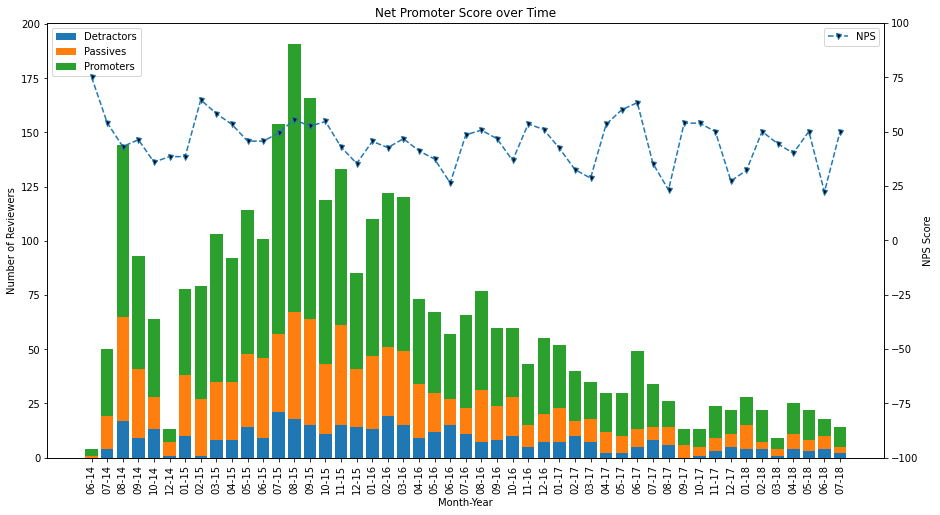

In [19]:
# plot of the NPS over years.
df = stacked_NPS

# set figure size
fig, ax1 = plt.subplots(figsize=(15,8))

# plot stacked bar for detractors, passives, and promoters
plt.bar(df['month-year'], df['detractors'], label='Detractors')
plt.bar(df['month-year'], df['passives'], bottom=df['detractors'], label='Passives')
plt.bar(df['month-year'], df['promoters'], bottom=df['detractors']+df['passives'], label='Promoters')

# set labels and legend for primary y-axis
ax1.set_xlabel('Month-Year')
ax1.set_ylabel('Number of Reviewers')
ax1.set_title('Net Promoter Score over Time')
ax1.legend(loc='upper left')

# create secondary y-axis for NPS score
ax2 = ax1.twinx()

# plot continuous line for NPS score
ax2.plot(df['month-year'], df['NPS'], label='NPS', linestyle='dashed', marker='v', markerfacecolor='black', markersize=5)

# set labels and legend for secondary y-axis
ax2.set_ylim(-100, 100)
ax2.set_ylabel('NPS Score')
ax2.legend()

# rotate x-axis labels to be vertical
ax1.tick_params(axis='x', rotation=90)

# display plot
plt.show()


**Comment** : From the above chart, we can see that the NPS score is fluctuating around 40 for all years. This is a very good score. It means among all tha customers that provided a review there is ~40% more customers that will recommend the peoduct than the ones that will not. A positive NPS is alwys good, the perfect scnario is an NPS = +100%, this means all customers are willing to recommend the product. It shows that even when the volume is high (between 2015 and 2016) the NPS score kept the same performance. 

In [20]:
# Globa NPS calculation
Promoter = round(stacked_NPS['promoters'].sum()/denominator.sum() *100,2)
Detractor = round(stacked_NPS['detractors'].sum()/denominator.sum()*100,2)
Passive = round(stacked_NPS['passives'].sum()/denominator.sum()*100,2)
NPS_Global = round(Promoter - Detractor,2)

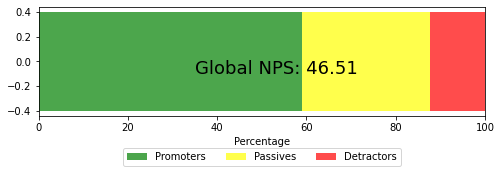

In [226]:
# Define the data for the plot
promoters_pct = Promoter
passives_pct = Passive
detractors_pct = Detractor
nps_score = NPS_Global

# Create the plot
fig, ax = plt.subplots(figsize=(8, 2))

# Plot the promoters
ax.barh(y=0, width=promoters_pct, color='green', alpha=0.7, label='Promoters')

# Plot the passives on top of the promoters
ax.barh(y=0, width=passives_pct, color='yellow', alpha=0.7, label='Passives', left=promoters_pct)

# Plot the detractors on top of the passives and promoters
ax.barh(y=0, width=detractors_pct, color='red', alpha=0.7, label='Detractors', left=promoters_pct+passives_pct)

# Set the x-axis limit and label
ax.set_xlim([0, 100])
ax.set_xlabel('Percentage')

# Add the NPS score text to the plot
ax.text(35, -0.1, f'Global NPS: {nps_score}', fontsize=18)

# Add a legend to the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)

# Show the plot
plt.show()

**Comment** : The overall NPS score is 46.51% which is a great one. It tells that we have 42.51% more customers than that will recommend the product than the one will criticize it. We should note the passives could impact this result if the model estimate them correctly. the worst case scenario is have an NPS=Promoter - (Detractors + Passives) = 17.84% which is still positive. 

## 5. Side by Side anylsis

In this section, we will compare side by side the review sentiment vs the reviewers type to check if all negative reviews are resulting detractors or not. Also we want to check the difference between BERT and GPT estimation of the sentiment.

### 5.1 Reveiew Sentiment vs Reviewers Type

In [251]:
# Data preparation stacked bars
stacked_analysis = stacked_reviews
stacked_analysis['detractors'] = stacked_NPS['detractors'] 
stacked_analysis['passives'] = stacked_NPS['passives']
stacked_analysis['promoters'] = stacked_NPS['promoters']
stacked_analysis['NPS'] = stacked_NPS['NPS']

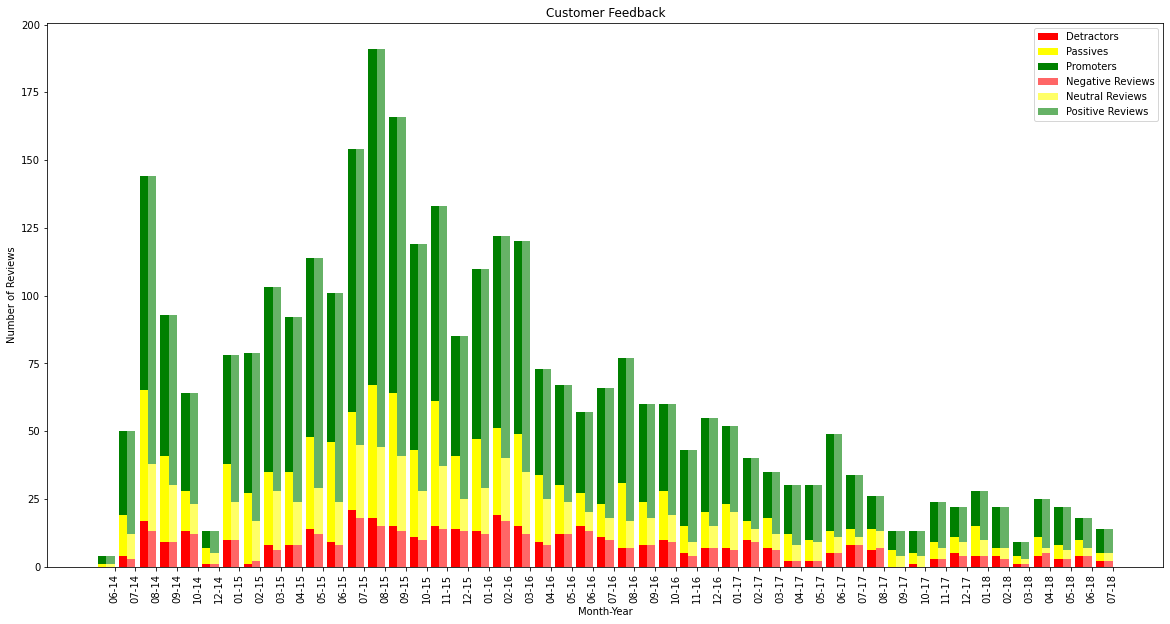

In [275]:
# plot side by side of two 
df = stacked_analysis

# create stacked bar chart
fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.4
months = np.arange(len(df))

ax.bar(months - 1.5*bar_width, df['detractors'], width=bar_width, label='Detractors', color='red')
ax.bar(months - 1.5*bar_width, df['passives'], bottom=df['detractors'], width=bar_width, label='Passives', color='yellow')
ax.bar(months - 1.5*bar_width, df['promoters'], bottom=df['detractors']+df['passives'], width=bar_width, label='Promoters', color='green')

ax.bar(months - 0.5*bar_width, df['negative_reviews'], width=bar_width, label='Negative Reviews', color='red', alpha=0.6)
ax.bar(months - 0.5*bar_width, df['neutral_reviews'], bottom=df['negative_reviews'], width=bar_width, label='Neutral Reviews', color='yellow', alpha=0.6)
ax.bar(months - 0.5*bar_width, df['positive_reviews'], bottom=df['negative_reviews']+df['neutral_reviews'], width=bar_width, label='Positive Reviews', color='green', alpha=0.6)

ax.set_xlabel('Month-Year')
ax.set_ylabel('Number of Reviews')

ax.set_title('Customer Feedback')

ax.set_xticks(months)
ax.set_xticklabels(df['month-year'], rotation=90)

ax.legend()
plt.show()


**Comment:** We can see from the above chart that almost all the negative reviews results in detractors customers. However, we can notice that for postive reviews they are significant numbers of reviewrs that are estimated as passive. The model wasn't sure if the provided review was from a customer that can recommend the product. This is usually due to reviews that have mix of sentiment and that have good and bad experince. 

### 5.2 BERT vs GPT

In [27]:
# # Data preparation of BERT estimates
data_Bert = dat.drop(['Unnamed: 0','reviewerID','asin','summary','unixReviewTime','reviewText_deep_clean'], axis=1)
for i in data_Bert.index:
    if data_Bert['Sentiment_Score'][i] >= 4:
        data_Bert['Sentiment_BERT_Score'][i] = 1
    elif data_Bert['Sentiment_Score'][i]<= 2:
        data_Bert['Sentiment_BERT_Score'][i] = -1
    else:
        data_Bert['Sentiment_BERT_Score'][i] = 0

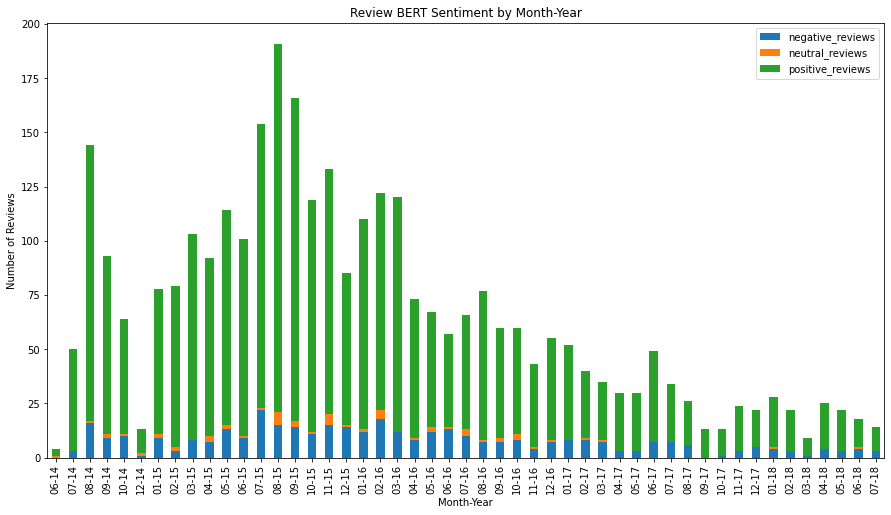

In [311]:
# plot of BERT estimates
data_Bert = data_Bert[['year','month','Sentiment_BERT_Score']]
# rearrange the data_Sent dataframe
grouped_reviews = data_Bert.groupby(['year', 'month', 'Sentiment_BERT_Score'])['Sentiment_BERT_Score'].count().unstack(fill_value=0)
grouped_reviews = grouped_reviews.reset_index()

# rename the columns
grouped_reviews.columns = ['year', 'month', 'negative_reviews', 'neutral_reviews', 'positive_reviews']

# assuming the grouped_reviews dataframe
grouped_reviews['month-year'] = pd.to_datetime(grouped_reviews['year'].astype(str) + '-' + grouped_reviews['month'].astype(str))
stacked_reviews = grouped_reviews.drop(columns=['year', 'month'])

# format the month-year column
stacked_reviews['month-year'] = stacked_reviews['month-year'].dt.strftime('%m-%y')

# create the stacked bar chart
fig, ax = plt.subplots(figsize=(15,8))
stacked_reviews.plot(kind='bar', stacked=True, x='month-year', ax=ax)

ax.set_xlabel('Month-Year')
ax.set_ylabel('Number of Reviews')
ax.set_title('Review BERT Sentiment by Month-Year')

plt.show()


In [28]:
# Data preparation
stacked_analysis['negative_bert'] = grouped_reviews['negative_reviews'] 
stacked_analysis['neutral_bert'] = grouped_reviews['neutral_reviews']
stacked_analysis['positive_bert'] = grouped_reviews['positive_reviews']

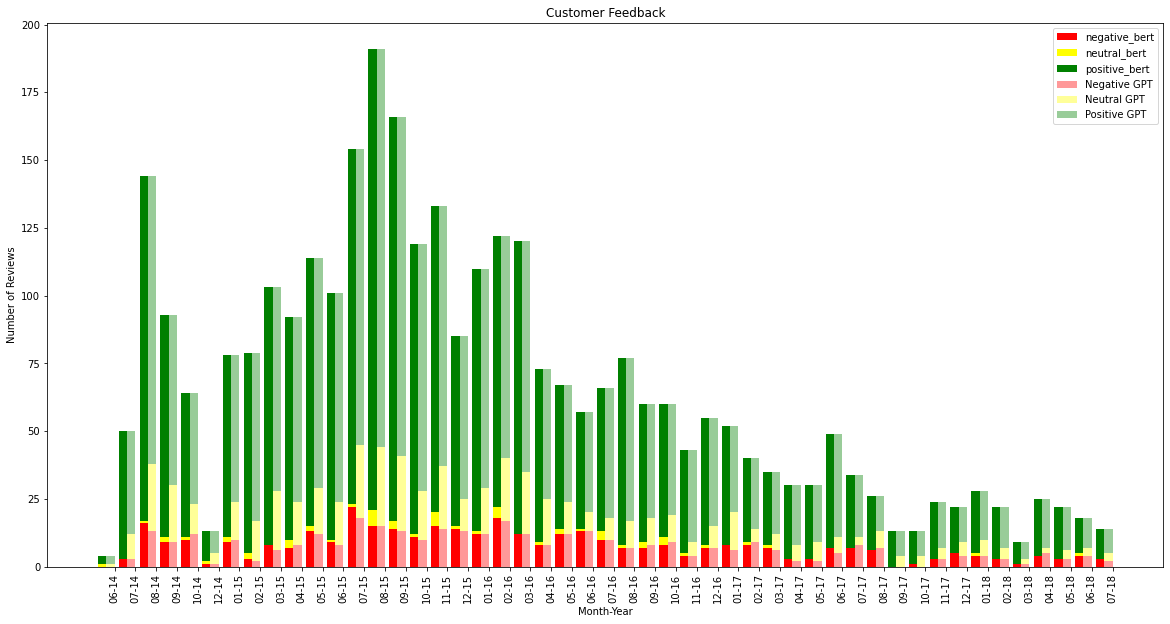

In [319]:
# Side by side plot
df = stacked_analysis

# create stacked bar chart
fig, ax = plt.subplots(figsize=(20, 10))

bar_width = 0.4
months = np.arange(len(df))

ax.bar(months - 1.5*bar_width, df['negative_bert'], width=bar_width, label='negative_bert', color='red')
ax.bar(months - 1.5*bar_width, df['neutral_bert'], bottom=df['negative_bert'], width=bar_width, label='neutral_bert', color='yellow')
ax.bar(months - 1.5*bar_width, df['positive_bert'], bottom=df['negative_bert']+df['neutral_bert'], width=bar_width, label='positive_bert', color='green')

ax.bar(months - 0.5*bar_width, df['negative_reviews'], width=bar_width, label='Negative GPT', color='red', alpha=0.4)
ax.bar(months - 0.5*bar_width, df['neutral_reviews'], bottom=df['negative_reviews'], width=bar_width, label='Neutral GPT', color='yellow', alpha=0.4)
ax.bar(months - 0.5*bar_width, df['positive_reviews'], bottom=df['negative_reviews']+df['neutral_reviews'], width=bar_width, label='Positive GPT', color='green', alpha=0.4)

ax.set_xlabel('Month-Year')
ax.set_ylabel('Number of Reviews')

ax.set_title('Customer Feedback')

ax.set_xticks(months)
ax.set_xticklabels(df['month-year'], rotation=90)

ax.legend()
plt.show()


**Comment:** We can see from this side by side check is that BERT model has less neutral estimates. The model look to be more deterministic about the nature of the review, whereas GPT is more conservative. This can be explained by the fact that the used BERT is fine-tunes on product reviews sentiment analysis. On the other hand, GPT is trained on general text.

### -----------------------------------------------------------------------------------------------------------------------------------------------------
### End Part 2